In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
from copy import deepcopy
from concurrent.futures import ThreadPoolExecutor

## Step 1
Import data and make some exploratory analysis. Distance is normalized to the average, Population is normalized to the total population

In [2]:
cities = pd.read_csv('cityData.dat', header=None, sep='\t', index_col=0, names=['City', 'Population', 'Latitude', 'Longitude'])
cities.head()

,City,Population,Latitude,Longitude
0,Berlin,0.170716,52.52,13.38
1,Hamburg,0.087981,53.55,10.00
2,Munich,0.067102,48.14,11.58
3,Cologne,0.050797,50.95,6.97
4,Frankfurt,0.033703,50.12,8.68


In [3]:
cities.shape

(40, 4)

In [4]:
distances = pd.read_csv('cityDistances.dat', sep='\t', header= None, names=['Origin','Destiny','Distance'])
distances.head()

,Origin,Destiny,Distance
0,0,1,5.084382
1,0,2,10.082311
2,0,3,9.523469
3,0,4,8.456714
4,0,5,10.201078


In [5]:
distances.shape

(780, 3)

### Step 1.5
Try to define a graph with the data 

In [6]:
Nodes = [(i,cities.to_dict(orient='records')[i]) for i in range(cities.shape[0])]
Edges = [(distances.iloc[i,0],distances.iloc[i,1],{'weight': distances.iloc[i,2]}) for i in range(distances.shape[0])]

In [7]:
print(Nodes[:3])
print(Edges[:3])

[(0, {'City': 'Berlin', 'Population': 0.1707159963294827, 'Latitude': 52.52, 'Longitude': 13.38}), (1, {'City': 'Hamburg', 'Population': 0.0879805435806981, 'Latitude': 53.55, 'Longitude': 10.0}), (2, {'City': 'Munich', 'Population': 0.0671020343799828, 'Latitude': 48.14, 'Longitude': 11.58})]
[(0, 1, {'weight': 5.084381891841052}), (0, 2, {'weight': 10.082311312508343}), (0, 3, {'weight': 9.523468735599538})]


In [8]:
## Possible useful lists for a general graph
# edges = list(graph.edges) # list of tuples
# nodes = list(graph.nodes) 
# weights = [graph.get_edge_data(i[0],i[1],default=0)['weight'] for i in edges]

In [9]:
# This is a preliminary complete graph
G = nx.Graph()
G.add_nodes_from(Nodes)
G.add_edges_from(Edges)

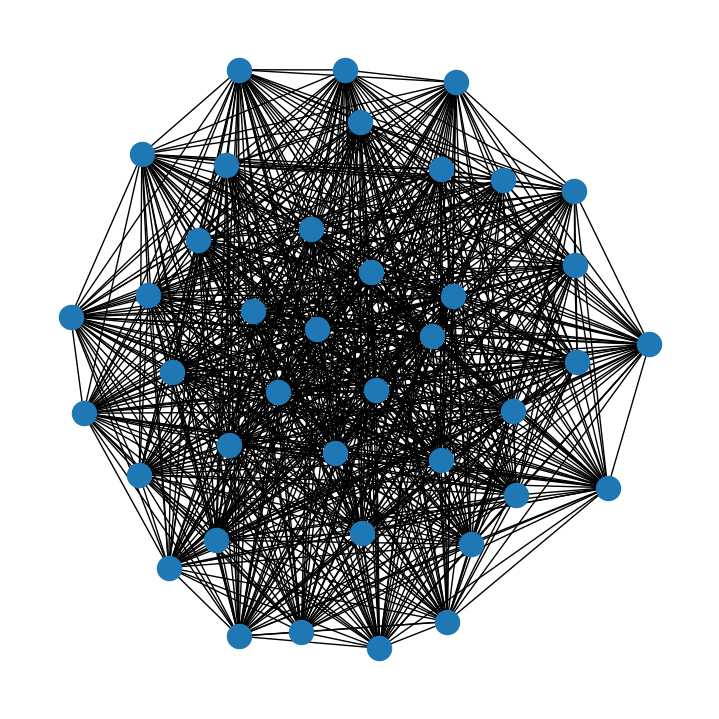

In [10]:
plt.figure(figsize=(7,7))
nx.draw(G)
plt.show()

In [11]:
# p = dict(nx.shortest_path_length(G, weight='weight'))
# [p[0][i] for i in range(cities.shape[0])]

# p = nx.shortest_path_length(G, source=0, target=13, weight='weight')
# p

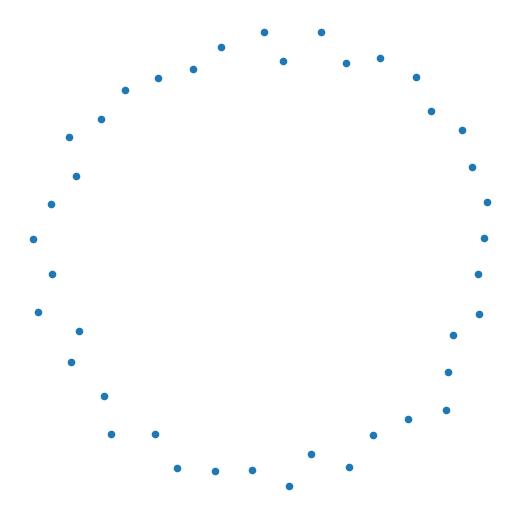

In [12]:
G0 = nx.Graph()
G0.add_nodes_from(Nodes)

G1 = G0.copy()
G1.add_edge(0,5,weight=1.2)

plt.figure(figsize=(5,5))
nx.draw(G0, node_size=20)
plt.show()

## Step 2
Define the cost functions
$$C_{tot} = C_{infra} + \gamma C_{trans}$$
$$C_{infra} = \sum_{e_{ij}\in E}d(e_{ij}) $$
$$C_{trans} = \frac{1}{2} \sum_{i,j \in V} P_i P_j ~ \tilde{d}_{ji} $$

Where $ \tilde{d}_{ji}$ is defined by

$$ \tilde{d}(e_{ij}) = (1-\delta) d(e_{ij}) + \delta $$

In [13]:
def C_infra(graph, paths=None):
    if paths is None:
        paths = dict(nx.shortest_path_length(graph, weight='weight'))

    num_nodes = len(graph.nodes)
    shortest_path_lengths = np.zeros((num_nodes, num_nodes))
    
    for i in range(num_nodes):
        for j in range(num_nodes):
            shortest_path_lengths[i][j] = paths[i].get(j, np.Inf)

    return 0.5 * np.sum(shortest_path_lengths)


In [14]:
C_infra(G)

4445.97350006116

In [15]:
def eff_len(graph, i, j, δ, d_ij=None):
    if d_ij is None:
        d_ij = nx.shortest_path_length(graph, source=i, target=j, weight='weight') 
    return (1-δ)*d_ij + δ

In [16]:
eff_len(G, 0, 2, 0.33)

7.085148579380589

In [17]:
def C_trans(graph, δ, paths=None, Pop=None):
    if paths is None:
        paths = dict(nx.shortest_path_length(graph, weight='weight'))
    if Pop is None:
        Pop = nx.get_node_attributes(graph, name='Population')

    num_nodes = len(graph.nodes)
    sum_ = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            sum_ += Pop[i] * Pop[j] * eff_len(graph, i, j, δ, paths[i].get(j))
    return 0.5 * sum_

In [18]:
delta= 0.33
gamma = 200
C_trans(G, delta)

2.2012222584940466

In [19]:
def C_tot(graph, γ, δ, paths=None, Pop=None):
    if paths is None:
        paths = dict(nx.shortest_path_length(graph, weight='weight'))
    if Pop is None:
        Pop = nx.get_node_attributes(graph, name='Population')

    infra_cost = C_infra(graph, paths)
    trans_cost = C_trans(graph, δ, paths, Pop)

    return infra_cost + γ * trans_cost

In [20]:
print(C_infra(G)) # This is going to be large, because G is a complete network
print(C_trans(G,delta))
print(C_trans(G,delta)*gamma)
print(C_tot(G,gamma,delta))

4445.97350006116
2.2012222584940466
440.2444516988093
4886.217951759969


## Step 3

Implement the Metropolis algorithm. Start with a random graph and start removing and adding edges to see if the cost function is reduced.

In [21]:
def Metropolis_step(graph, γ, δ, T=1):
    link = sample(list(graph.nodes), 2)
    while link[0] == link[1]:
        link = sample(list(graph.nodes), 2)
    
    pop = nx.get_node_attributes(graph, name='Population')
    old_cost = C_tot(graph, γ, δ, Pop=pop)
    
    if graph.has_edge(*link):
        graph.remove_edge(*link)
    else:
        graph.add_edge(*link)
    
    new_cost = C_tot(graph, γ, δ, Pop=pop)
    ΔC = new_cost - old_cost
    
    if ΔC < 0 or np.exp(-ΔC / T) < 1:
        return graph, new_cost
    else:
        if graph.has_edge(*link):
            graph.remove_edge(*link)
        else:
            graph.add_edge(*link)
        return graph, old_cost

In [22]:
def process_delta(del_val, gamma, T_values, N, G):
    costs = []
    G2 = deepcopy(G)
    for temp_idx, temp in enumerate(T_values):
        for _ in range(N):
            G2, graph_cost = Metropolis_step(G2, gamma, del_val, temp)

        costs.append(graph_cost)
        if temp_idx % 10 == 0:
            print(f"Delta: {del_val}, Temperature: {temp}")
    return del_val, costs, G2

if __name__ == '__main__':
    delta = [0, 1/3, 2/3, 1]
    gamma = 200
    T = np.linspace(10, 0.1, 100)
    N = 200
    costs_delta = []
    last_graph = []

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(process_delta, del_val, gamma, T, N, G) for del_val in delta]
        
        for future in futures:
            del_val, costs, graph = future.result()
            costs_delta.append(costs)
            last_graph.append(graph)
            print(f"Finished processing delta = {del_val}")

    # print(costs_delta)
    # Use or save last_graph as needed

Delta: 0.6666666666666666, Temperature: 10.0
Delta: 0.3333333333333333, Temperature: 10.0
Delta: 0, Temperature: 10.0
Delta: 1, Temperature: 10.0
Delta: 0, Temperature: 9.0
Delta: 0.3333333333333333, Temperature: 9.0
Delta: 0.6666666666666666, Temperature: 9.0
Delta: 1, Temperature: 9.0
Delta: 0, Temperature: 8.0
Delta: 0.3333333333333333, Temperature: 8.0
Delta: 0.6666666666666666, Temperature: 8.0
Delta: 1, Temperature: 8.0
Delta: 0, Temperature: 7.0
Delta: 0.3333333333333333, Temperature: 7.0
Delta: 0.6666666666666666, Temperature: 7.0
Delta: 1, Temperature: 7.0
Delta: 0, Temperature: 6.0
Delta: 0.3333333333333333, Temperature: 6.0
Delta: 0.6666666666666666, Temperature: 6.0
Delta: 1, Temperature: 6.0
Delta: 0, Temperature: 5.0
Delta: 0.3333333333333333, Temperature: 5.0
Delta: 0.6666666666666666, Temperature: 5.0
Delta: 1, Temperature: 5.0
Delta: 0, Temperature: 4.0
Delta: 0.3333333333333333, Temperature: 4.0
Delta: 0.6666666666666666, Temperature: 4.0
Delta: 1, Temperature: 4.0
De

In [23]:
for del_val in delta:
    i = 0
    with open('CompNet_Delta{: .2f}.txt'.format(del_val),'w') as file:
        for temp,cost in zip(T,costs_delta[i]):
            file.write(f'{temp}, {cost}\n')
        i += 1

In [26]:
for i, graph in enumerate(last_graph):
    filename = f"Graph_delta_{delta[i]}_CompNet.adjlist"
    
    # Save graph to adjacency list
    nx.write_adjlist(graph, filename)
    print(f"Graph {i} (delta = {delta[i]}) saved as adjacency list: {filename}")

Graph 0 (delta = 0) saved as adjacency list: Graph_delta_0_CompNet.adjlist
Graph 1 (delta = 0.3333333333333333) saved as adjacency list: Graph_delta_0.3333333333333333_CompNet.adjlist
Graph 2 (delta = 0.6666666666666666) saved as adjacency list: Graph_delta_0.6666666666666666_CompNet.adjlist
Graph 3 (delta = 1) saved as adjacency list: Graph_delta_1_CompNet.adjlist


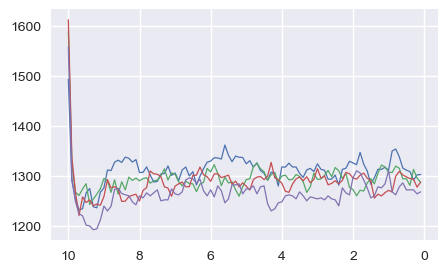

In [28]:
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(5,3))
for i in range(len(delta)):
    plt.plot(T,costs_delta[i],lw=0.9)
plt.gca().invert_xaxis()
plt.show()

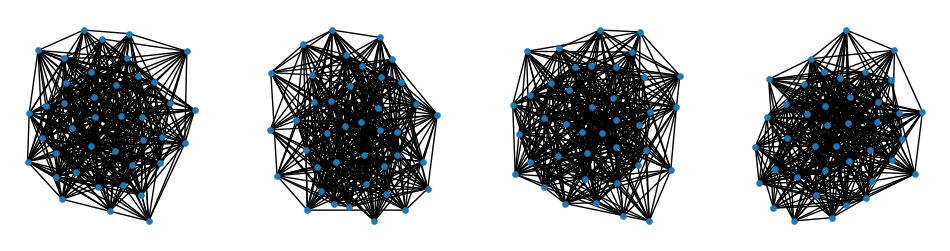

In [27]:
fig, axs = plt.subplots(1,4,figsize=(12,3))
for i in range(4):
    nx.draw(last_graph[1], node_size=20, ax=axs[i])
plt.show()